# System Dynamics 2
## EGR 557 Foldable Robotics
### Team 7

- Claudio Vignola

- Chien-Wen Pan

- Manoj Akkaraboina

- Dallas Wells


In [ ]:
# RUN PIP INSTALL CODE BLOCK

# Install standard packages...
!pip install meshio pygmsh ezdxf pandoc-fignos pandoc-eqnos pypdf4 service_identity ftd2xx pygithub twine paho-mqtt
!pip install ntplib pygame pysftp pyserial

# Install foldable-robotics-specific packages.
!pip install pypoly2tri idealab_tools foldable_robotics pynamics

In [ ]:
# import packages
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle, PseudoParticle
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
#from pynamics.constraint import Constraint
import scipy.optimize


In [ ]:
global_q = True
use_constraints = False

# Create Pynamic system
system = System()
pynamics.set_system(__name__,system)

# Define constants and variables

g = Constant(9.81,'g',system)

# Add joint stiffness.
b = Constant(1e0,'b',system)
bS = Constant(0.6,'b',system)
k1 = Constant(1e1,'k1',system)
k2 = Constant(1e0,'k2',system)
#b_cboard = Constant (0e0, 'b_cboard', system)
#k_cboard = Constant (0e0, 'k_cboard', system)
#b_cstock = Constant (0e0, 'b_cstock', system)
#k_cstock = Constant (0e0, 'k_cstock', system)
#b_balsa = Constant (0e0, 'b_balsa', system)
#k_balsa = Constant (0e0, 'k_balsa', system)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preloadS1 = Constant(-90*pi/180,'preloadS1',system)
preloadS2 = Constant(0*pi/180,'preloadS2',system)

# Integration tolerance
tol = 1e-9

# Time
tinitial = 0
tfinal = 15
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

# Differential state variables
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qS1,qS1_d,qS1_dd = Differentiable('qS1',system)
qS2,qS2_d,qS2_dd = Differentiable('qS2',system)

# Initial values
initialvalues = {}
initialvalues[qA]=120*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=-60*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qS1]=-37.6*pi/180
initialvalues[qS1_d]=0*pi/180
initialvalues[qS2]=-141.6*pi/180
initialvalues[qS2_d]=0*pi/180

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

# Define frames and frames rotations
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')
# M = Frame('M')

S1 = Frame('S1')
S2 = Frame('S2')

system.set_newtonian(N)

if not global_q:
    A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
    B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
    C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)
    S1.rotate_fixed_axis_directed(B,[0,0,1],qS1,system)
    S2.rotate_fixed_axis_directed(S1,[0,0,1],qS2,system)
else:
    A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
    B.rotate_fixed_axis_directed(N,[0,0,1],qB,system)
    C.rotate_fixed_axis_directed(N,[0,0,1],qC,system)
    S1.rotate_fixed_axis_directed(N,[0,0,1],qS1,system)
    S2.rotate_fixed_axis_directed(N,[0,0,1],qS2,system)

### 1. Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.

## **Bill Of Materials**

| *Table 1. Material Selection* |
| - |

| Material | Cost $ | Reasoning | Link or Origin |
|------|-----|-----|-----|
| Cardstock | 4.97 | First Prototyped Model, Might be used as a bend for storing energy  | https://www.walmart.com/ip/Pen-Gear-Card-Stock-Paper-Assorted-Bright-8-5-x-11-65-lb-100-Sheets/245310905 | 
| Orange Spring | Free  | Relative low energy metal spring | ASU |
| Yellow Spring | Free  | Longer and stronger metal spring compared to Yellow | ASU |
| Cardboard |  1.48  | Stiffening 1A,1B,1C, and 1D for second Model | https://www.homedepot.com/p/The-Home-Depot-Medium-Moving-Box-22-in-L-x-16-in-W-x-15-in-D-MDMVEBX/307808469 | 
|  Super Glue   |  3.47  |  Connection between links  |  https://www.walmart.com/ip/Loctite-Ultra-Liquid-Control-0-14-fl-oz-Bottle/23760455  | 
| **Total** | 9.92  |

### **Model 1 with Data for Mass**

Below in Figure 1 there are the 4 model created to study our kinematics, we consider this our first prototype. 

![Set Up Image](https://drive.google.com/uc?id=1jsMFS8HBf2ITKU7NzktH7fNMY-fnjxWM)
*Figure 1. First Prototype*

| *Table 2. Links Kinematics First Prototype* |
| - |

| Link | Material | Units (gsm) | Length (m) | Mass (kg) |
|------|--------|------|-----|----|
|  lA   | Cardstock | 176 |  0.07  |  0.0004752  | 
|  lB   | Cardstock | 176 |  0.18  |  0.001056   |
|  lC   | Cardstock | 176 |  0.07  |  0.0004752  |
|  lD   | Cardstock | 176 |  0.05  |  0.0004224  |

The lengths of each link are obtain from our Physical Design.

**1A** and **1C**
$$ \frac {176}{1} = \frac { x }{(0.03 * 0.07)} $$

$$ {x} =  { 176 *(0.03 * 0.07)} = {0.4752}{g} = {0.0004752 kg}$$

**1B**
$$ \frac {176}{1} = \frac { x }{(0.03 * 0.18)} $$

$$ {x} =  { 176 *(0.03 * 0.18)} = {0.9504}{g} = {0.0009504 kg}$$

Account for extra paper to attached for tabs

$$ {x} = {0.9504} + {2* 176 *(0.03 * 0.01)}  = {1.056}{g} = {0.001056 kg}$$

**1D**
$$ \frac {176}{1} = \frac { x }{(0.03 * 0.06)}$$

$$ {x} =  { 176 *(0.03 * 0.06)} = {0.3168}{g} = {0.0003168 kg}$$

Account for extra paper to attached for tabs

$$ {x} = {0.3168} + {2* 176*(0.03 * 0.01)}  = {0.4224}{g} = {0.0004224 kg}$$


The lengths of each links are obtain from our kinematic design.

### **Model 2 with Data for Mass**

| *Table 3. Links Kinematics Second Prototype* |
| - |

| Link | Material | Units (gsm) | Length (m) | Mass (kg) |
|------|--------|------|-----|----|
|  lA   | Cardboard | 305 |  0.07  |  0.0006405  | 
|  lB   | Cardboard | 305 |  0.18  |  0.0019638   |
|  lC   | Cardboard | 305 |  0.07  |  0.0006405  |
|  lD   | Cardboard | 305 |  0.1025  |  0.001254675  |

The lengths of each link are obtain from our First Physical Design.

**Single wall B flute Cardboard**

$$ {Kraft+2*wall} =  {105+2*125}{gsm} = {305}{gsm}$$

**1A** and **1C**
$$ \frac {305}{1} = \frac { x }{(0.03 * 0.07)} $$

$$ {x} =  { 305 *(0.03 * 0.07)} = {0.6405}{g} = {0.0006405 kg}$$

**1B**
$$ \frac {305}{1} = \frac { x }{(0.03 * 0.18)} $$

$$ {x} =  { 305 *(0.03 * 0.18)} = {1.647}{g} = {0.001647 kg}$$

Account for extra paper to attached for tabs

$$ {x} = {1.647} + {2* 176 *(0.03 * 0.03)}  = {1.9638}{g} = {0.0019638 kg}$$

**1D**
$$ \frac {305}{1} = \frac { x }{(0.03 * 0.1025)}$$

$$ {x} =  { 305 *(0.03 * 0.1025)} = {0.937875}{g} = {0.000937875 kg}$$

Account for extra paper to attached for tabs

$$ {x} = {0.000937875} + {2* 176 *(0.03 * 0.03)}  = {1.254675}{g} = {0.001254675 kg}$$

The lengths of each links are obtain from our Second Physical Design.

### **K constant** 

**Mass of Single Cardstock Spring**
$$ {x} =  { 176 *(0.03 * 0.11)} = {0.5808}{g} = {0.0005808 kg}$$
**Mass of DoubleCardstock Spring**
$$ {x} =  { 2*176 *(0.03 * 0.11)} = {1.1616}{g} = {0.0011616 kg}$$


| *Table 4. K constant Info* |
| - |


| Spring | K constant (N/m) |Intial Spring Lenght (cm) | Max Spring Elongation (cm) |
|-----|-----|-----|-----|
|  Orange Spring   | 413.6  |  10.44  | 11.13 |
|  Yellow Spring   |  591.29  |  13.1  | 15.24 |
|  Cardstock Single  |  .  |  11.0  |  11.0  |
|  Cardstock Double   |  .  |  11.0  |  11.0  | 

To understand how the model would behave we created a prototype that has multiple points to attach the cardstock bend as shown in Figure 2. In this prototype the positions are set at 1cm from eachother starting from the 1C bar . In Figure 3 and 4 we can see the range of the attach points moving from 1 to 4 cm on the 1D bar and 1 to 12 cm on the 1A bar. 

![Set Up Image](https://drive.google.com/uc?id=1dwc2xnyjRDE_0B5bvkdrWcK_C_TkL8J4)
*Figure 2. Second Prototype with Cardstock 11cm bends (springs)*

![Set Up Image](https://drive.google.com/uc?id=1rpm07gxmkrlF7Jngx1MBw3e7tRvqrc5P)
*Figure 3. Bottom Bar 4 point division*

![Set Up Image](https://drive.google.com/uc?id=12L1F-aIQL-dJnA0dnDw_RfGw8WqUyCO4)
*Figure 4. Top Bar 12 points division*


Finally we designed the experiment and set the second prototype shown in Figure 5 in a bright environment. Slow mode videos were taken to compare the designs and to find the Ideal position for the bend. Test 1 to 8 used a 1/8 frames reduction, instead Test 9 used a 1/4 frames reduction to compare Test 8 and 9 results.

![Set Up Image](https://drive.google.com/uc?id=12-lOhYMTwbdMQG1QQiBl6bpZc0yBvFNB)
*Figure 5. Experiment Set up*

[Video Link Test 1 (Bottom 1 cm x Top 1 cm) ](https://drive.google.com/uc?id=1lzvcTosLsYDqjilrE3SqVrjI7IW83z7g)

[Video Link Test 2 (Bottom 1 cm x Top 12 cm) ](https://drive.google.com/uc?id=1udvSGtXU6DQp-aSOnDWqalBknvZwOwRm)

[Video Link Test 3 (Bottom 4 cm x Top 12 cm) ](https://drive.google.com/uc?id=1RBnR72_dBBev6AMgTQgXINwCEFUS25Mb)

[Video Link Test 4 (Bottom 4 cm x Top 1 cm) ](https://drive.google.com/uc?id=1cRxMe5b_umecQlY-nZ1c6jWHDj2uhP30)

[Video Link Test 5 (Bottom 2 cm x Top 7 cm) ](https://drive.google.com/uc?id=1_-FaBGc3R3vhvTTqCMuzmo6KEr7mcUeW)

[Video Link Test 6 (Outword Bend - Bottom 4 cm x Top 7 cm) ](https://drive.google.com/uc?id=1s413MChOT9FcKgsN4aJTlHJMoo5lHzgL)

[Video Link Test 7 (Inword Bend - Bottom 4 cm x Top 7 cm) ](https://drive.google.com/uc?id=11jcZjL8L8eTkfL7oW9icjZ92MWXIhDA9)

[Video Link Test 8 (Double Bend - Bottom 4 cm x Top 7 cm) ](https://drive.google.com/uc?id=1UmmkwRkqFxvVxJnNdGkB_iLTvWpy9EYA)

[Video Link Test 9 (Double Bend - Bottom 4 cm x Top 7 cm) ](https://drive.google.com/uc?id=1KYGInYVTIcdWnMoxNxkQnmSX3A0PvmsJ)

[Video Link Test 10 (Double Bend with Double Dot for Image Processing - Bottom 4 cm x Top 7 cm) ](https://drive.google.com/uc?id=1LKlMr8OhfCzU_DFwEKGMr0JsKk4BfHiv)

### Experiment Outcomes

What we found from comparing Test 6 and 7 is that by bending outwords the motion settels more forward than in inword. Also, it shows that the distance travelled is higher compared to inword. This allowed us to define the dynamics model of the spring to be in the same direction.

For the modeling, we simplify the compliant beam as two rigid beams with a spring connecting them in the middle.

![Set Up Image](https://drive.google.com/uc?id=1lUiW3hgzmUs37Dg2AH-Lypd10bJU99yy)

*Figure 6. Kinematic setting*


From our multiple prototypes, we pick d1 = 0.07 (m) and d2 = 0.04 (m) to be the location of our spring as a demo. The tracker result is shown.


![Set Up Image](https://drive.google.com/uc?id=1dQ1O1H5URKK8iKiEMtM9IMWxxA-a4Tzj)

*Figure 7. Tracker*

Then based on the kinematic results we got from tracker, we tune the damping ratio and stiffness of the spring for a more realistic modeling.

[Video of Tracker](https://drive.google.com/file/d/172c1KfDTsAn9-swinW9CxosAn_TeUXPO/view?usp=sharing)


In [ ]:
# Define constants and variables
lA = Constant(0.07,'lA',system)
lB = Constant(0.18,'lB',system)
lC = Constant(0.07,'lC',system)
lD = Constant(0.05,'lD',system)

lSpring1 = Constant(0.053,'l1',system) # upper part of the spring in pynamic model
lSpring2 = Constant(0.047,'l2',system) # lower part of the spring in pynamic model

d1 = Constant(0.07,'d1',system) # Distance from pBC to spring in upper linkage
d2 = Constant(0.04,'d2',system) # Distance from pCD to spring in base

mA = Constant(0.0006405,'mA',system)
mB = Constant(0.0019638,'mB',system)
mC = Constant(0.0006405,'mC',system)
# mM = Constant(0.001254675,'mM',system)
mS = Constant(0.0011616,'mS',system)

# Define kinematics
pNA = 0*N.x + 0*N.y
pAB = pNA + lA*A.x
pBtip = pAB + lB*B.x
pBC = pAB + lD*B.x
pCD = pBC + lC*C.x

pSpring1 = pBC + d1*B.x
pSpring1tip = pSpring1 + lSpring1*S1.x
pSpring2tip = pSpring1tip + lSpring2*S2.x

pSpring2end = pCD + d2*N.x

points = [pNA,pAB,pBtip,pSpring1, pSpring1tip, pSpring2tip, pSpring1tip, pSpring1, pBC,pCD]
# points = [pNA,pAB,pBtip,pBC,pCD]

### 2. Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame. You may use particles for now if you are not sure of the inertial properties of your bodies, but you should plan on finding these values soon for any “payloads” or parts of your system that carry extra loads (other than the weight of paper).

**Center of Mass**

Since the main material of our device body is paper and its uniform, the center of mass is located at the center of the body.

**Inertia**

In order to model the inertial components of each link in the system, a 3D CAD model of the system was created in SolidWorks. Measuring the weight and dimensions of 5 samples of material an average density was calculated, and set into the Solidworks material properties. Then the inertia for each link was calculated from the Mass Properties tool in Solidworks for each of the separate link parts.

**Link Stiffness**

In order to model the stiffness values of our link materials, a MATLAB code was created. The code uses the built-in image processor to load a series of 15 pictures. These pictures are of 3 samples of the material with 5 different loads applied to them, taken against a 1 cm grid system. The distance between the grid squares can then be marked in the image processor to create a baseline scale. Then for each of the pictures, the deflection is measured within the image processor, and normalized to the 1 cm scale. The deflection per unit force is then calculated by applying a linear curve fit to each of the three samples and averaging the slopes. Using this deflection data, the Young’s modulus of the material is calculated, and from that value the stiffness is calculated.

![Set Up Image](https://drive.google.com/uc?id=1wAXbEUmxei86P2HmSThEiFRkpUhUVT2G)

*Figure 8. CAD Front View*

![Set Up Image](https://drive.google.com/uc?id=1uc5KGKZx76clgtt4inZz7HaGcGLePFC0)

*Figure 9. CAD Isometric View*



In [ ]:
# Add inertia. In the following code, we use point mass before we have the more realistic values of inertia. Therefore, all inertial values are 1 for now.
Ixx_A = Constant(4.5,'Ixx_A',system)
Iyy_A = Constant(1.5,'Iyy_A',system)
Izz_A = Constant(6,'Izz_A',system)
Ixx_B = Constant(176.1,'Ixx_B',system)
Iyy_B = Constant(183.6,'Iyy_B',system)
Izz_B = Constant(7.7,'Izz_B',system)
Ixx_C = Constant(4.5,'Ixx_C',system)
Iyy_C = Constant(1.5,'Iyy_C',system)
Izz_C = Constant(6,'Izz_C',system)

Ixx_S = Constant(3,'Ixx_S',system)
Iyy_S = Constant(1,'Iyy_S',system)
Izz_S = Constant(3,'Izz_S',system)

# Center of mass
pAcm = pNA+lA/2*A.x
pBcm = pAB+lB/2*B.x
pCcm = pBC+lC/2*C.x

pS1cm = pSpring1 + lSpring1/2*S1.x
pS2cm = pSpring1tip + d2/2*S2.x

# Angular velocity
wNA = N.getw_(A)
wAB = A.getw_(B)
wBC = B.getw_(C)
wBS1 = B.getw_(S1)
wS12 = S1.getw_(S2)

# Define body
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)

IS1 = Dyadic.build(S1,Ixx_S,Iyy_S,Izz_S)
IS2 = Dyadic.build(S2,Ixx_S,Iyy_S,Izz_S)

# BodyA = Particle(pAcm,mA,'ParticleA',system)
# BodyB = Particle(pBcm,mB,'ParticleB',system)
# BodyC = Particle(pCcm,mC,'ParticleC',system)
BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)

BodyS1 = Body('BodyS1',S1,pS1cm,mS,IS1,system)
BodyS2 = Body('BodyS2',S2,pS2cm,mS,IS2,system)

# 3. Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint. You do not need to add external motor/spring forces but you should start planning to collect that data.

## **Modeling a spring actuator[1]:**

The spring will be modeled by stretching the spring with several known amounts of masses under gravity. When the mass is suspended to the spring vertically and the spring does not have any motion, then there is no acceleration and the spring is in equillibrium. It means that the net force in the vertical direction is zero. The force diagram for the mass along with the forces can be seen below
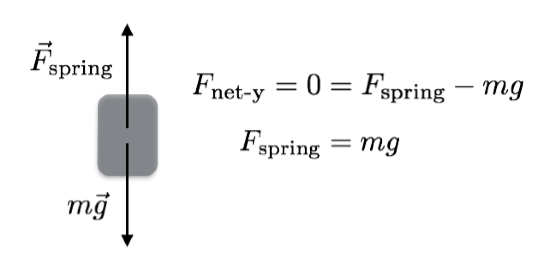

Fspring - The force the spring exerts

mg - Force exerted by the mass 'm' under gravity 'g'

Fnet-y - Net force applied on the spring due to the suspended mass

If a larger mass is kept on the end of the spring, the new larger mass will hand lower. The spring will stretch. Different masses will be suspended at the bottom of the spring and the stretch of the spring will be recorded. Multiplying the different suspended masses with gravitaional force gives the spring force. Plot a curve with the spring force and stretch of the spring. 

The expression for the force the spring exerts can be written as:
Fspring = KS

K - Spring constant

S - stretch of the spring

For the spring, this constant would have a value equal to the slope of the linear function. (Hooke's law)

**Modeling the motion of the spring**

Let us model the oscillations of the spring when a mass is suspended. The kinematic equations cannot be used to find out how long a mass would take to osciallte the spring. The key part of the kinematic equations is the idea that the acceleration is constant. Since we have a changing force, we will have changing acceleration. So we have to look at the motion of the spring in just a very short time frame. We can use the momentum principle to describe the change in motion of the mass.

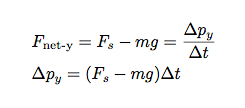

Py - position of the suspended mass.

t - time


The change in momentum and the change in position can be obtained by the following equations:

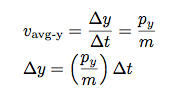

In this short time interval, the new momentum can be calculated and the new position of the mass can be identified. Since the time interval is so small, this calculation will be redone many times for multiple positions. If the position of the mass and the time are plotted on a graph, then the resulting plot will be a sinusoidal wave.


A damper is added at the input joint (pNA). Other joints are assumed to be fully free (no damping, and no spring).

Note that although we have damping and spring formulation in the code the values (b and k) are set to zero in the previous code.





In [ ]:
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-bS*wBS1,wBS1)
system.addforce(-bS*wS12,wS12)

# Spring force
if not global_q:
    # system.add_spring_force1(k1,(qS1-preloadS1)*S1.z,wBS1)
    system.add_spring_force1(k2,(qS2-preloadS2)*S2.z,wS12)
    # system.add_spring_force1(k,(qA-preload1)*N.z,wNA)
    #system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
    #system.add_spring_force1(k,(qC-preload3)*B.z,wBC)
else:
    system.add_spring_force1(k1,(qS1-preloadS1)*N.z,wBS1)
    system.add_spring_force1(k2,(qS2-preloadS2)*N.z,wS12)
    # system.add_spring_force1(k,(qA-preload1)*N.z,wNA)
    #system.add_spring_force1(k,(qB-qA-preload2)*N.z,wAB)
    #system.add_spring_force1(k,(qC-qB-preload3)*N.z,wBC)
    
# Gravity force
system.addforcegravity(-g*N.y)

Since the purpose of our servo motor is just pulling the device back to initial position instead of doing any propelling, we decided to get rid of the motor and just set a proper initial position.
The parameters of our servo motor is listed below in the code in case we need it in the future. 

In [ ]:
# # Add a motor input

# L = Constant(1,'L',system) # Inductance
# V = Constant(4.8,'V',system) # units is volts
# R = Constant(800,'R',system) # units is ohms
# Im = Constant(6,'Im',system) # units is mA
# Il = Constant(220,'Il',system) # units is mA
# G = Constant(1,'G',system) # Gravity
# kv = Constant(0.1,'kv',system) # Back EMF
# kt = Constant(0.02,'kt',system)
# Tl = Constant(1,'Tl',system) # 

# i,i_d= Differentiable('i',ii=1,system=system)
# pO = pNA
# aNA = wNA.time_derivative()

# I_motor = Dyadic.build(B,Im,Im,Im)
# I_load = Dyadic.build(B,Il,Il,Il)

# Motor = Body('Motor',A,pO,0,I_motor,system,wNBody = wNA,alNBody = aNA)
# Inductor = PseudoParticle(0*M.x,L,name='Inductor',vCM = i*M.x,aCM = i_d*M.x)

# #T = kt*(V/R)-kv*G*qB_d
# T = kt*i
# system.addforce(T*N.z,wNA)
# system.addforce(-Tl*B.z,wNA)
# system.addforce((V-i*R - kv*G*qB_d)*M.x,i*M.x)

# 4. Constraints: Keep mechanism constraints in, but follow the pendulum example of double-differentiating all constraint equations. --- If you defined your mechanism as unattached to the Newtonian frame, add enough constraints so that it is fully attached to ground (for now). you will be eventually removing these constraints.

The last tip of the four bar mechanism (pCD) is fixed to the ground. Also the two springs are connected head to head while the other ends of the springs are attached to the upper and lower beam seperately with distance assigned in the code. The end attached to the lower beam is also fixed at the ground.

In [ ]:
# Define constraints

eq = []
eq.append(pCD.dot(N.x))
eq.append(pCD.dot(N.y))
eq.append(pSpring2tip.dot(N.x))
eq.append(pSpring2tip.dot(N.y))

eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

# 5. Solution: Add the code from the bottom of the pendulum example for solving for f=ma, integrating, plotting, and animating. Run the code to see your results. It should look similar to the pendulum example with constraints added, as in like a rag-doll or floppy

In [ ]:
f,ma = system.getdynamics()

func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

states = pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))


2021-03-20 06:51:32,702 - pynamics.system - INFO - getting dynamic equations
2021-03-20 06:51:33,295 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-20 06:51:33,304 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-20 06:51:33,465 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-20 06:51:33,466 - pynamics.system - INFO - calculating function for lambdas
2021-03-20 06:51:33,468 - pynamics.integration - INFO - beginning integration
2021-03-20 06:51:33,470 - pynamics.system - INFO - integration at time 0000.00
2021-03-20 06:51:33,708 - pynamics.integration - INFO - finished integration


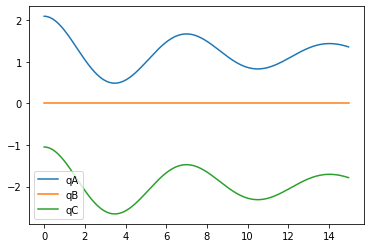

In [ ]:
# Plot --- output
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

2021-03-20 06:51:34,185 - pynamics.output - INFO - calculating outputs
2021-03-20 06:51:34,226 - pynamics.output - INFO - done calculating outputs


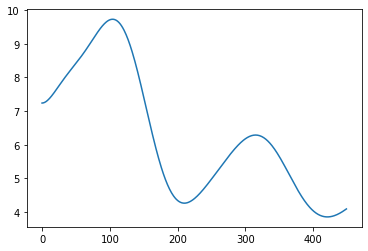

In [ ]:
# Plot --- energy

KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states)
energy_output.plot_time()

2021-03-20 06:51:34,462 - pynamics.output - INFO - calculating outputs
2021-03-20 06:51:34,496 - pynamics.output - INFO - done calculating outputs


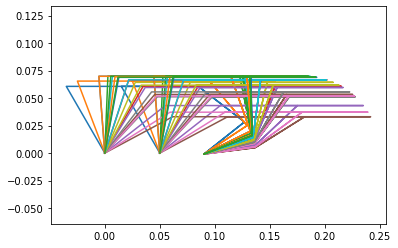

In [ ]:
# Motion
points = [pNA,pAB,pBtip,pSpring1, pSpring1tip, pSpring2tip, pSpring1tip, pSpring1, pBC,pCD]
# points = [pNA,pAB,pBtip,pBC, pCD]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

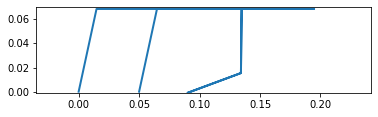

In [ ]:
points_output.animate(fps = 30,lw=2)

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())


From the animation above, we see that because we set the neutral position of the device to stand straight (vertical sides for the four-bar mechanism), our device would not just freely drop to the ground.
At the end, the energy dissipate and the device stops at a certain position similar to the physical prototype.


![Set Up Image](https://drive.google.com/uc?id=19QMRZgtId3OADkDUAMYwcfmEAwBlboIJ)

*Figure 10. Tracker*

[Tracker Video with Data](https://drive.google.com/file/d/12-4Hd2moa9ISf2X7lQj09nBZCAboAmce/view?usp=sharing)





# References:
[1] R. Allain, "How Do You Model a Spring?", Wired, 2014. [Online]. Available: https://www.wired.com/2014/07/how-do-you-model-a-spring/. 